In [2]:
# Get all expirations for options (HISTORIC EXPIRATION DATES)
# get all strikes for each of these expirations
    
# Get a dataframe with 'date', 'price' and '30 day realised volatility' of the underlying

# SATURDAY FOLLOWING THE THIRD FRIDAY OF EVERY MONTH
# So we take the intersection of ALL Expiries that polygon has data for. and the 3rd fridays and following saturday dates for every month

# So we get the list of expirations on that friday or saturday every month


# This is our entire list of possible options 

# Then, for each trading day, we find which option from our population is closest to the '30 day', 60, 90, 120 

# 

# Getting the stock price data

In [2]:
from polygon import RESTClient
from datetime import datetime, timedelta
import pandas as pd
import json

# Initialize the client with your Polygon API key
api_key = "ftdnhkJhYOsOYJjqbGXi4Vxs7QuEOZYH"
client = RESTClient(api_key)

stockTicker = 'AAPL'

dataRequest = client.get_aggs(ticker = stockTicker, 
                              multiplier = 1,
                              timespan = 'day',
                              from_ = '2022-12-01',
                              to = '2024-11-29')



# list of polygon agg objects to DataFrame
priceData = pd.DataFrame(dataRequest)

#create Date column
priceData['Date'] = priceData['timestamp'].apply(
                          lambda x: pd.to_datetime(x*1000000).date())

priceData = priceData[['Date', 'close']]
priceData.rename(columns={'close': 'close_u'}, inplace=True)


# Calculating the 30 day realised Volatility

In [3]:
import numpy as np

def calculate_monthly_volatility(df):
    # Calculate daily returns
    df['daily_return'] = df['close_u'].pct_change()
    
    # Calculate rolling 21-day standard deviation of daily returns
    # This gives us the "30-day" (21 trading days) volatility in daily terms
    df['monthly_volatility'] = df['daily_return'].rolling(window=21).std()
    
    # Annualize the volatility by multiplying by sqrt(252)
    df['monthly_volatility'] *= np.sqrt(252)
    
    return df

priceData = calculate_monthly_volatility(priceData)

In [4]:
# Relevant Expiry Dates
trading_days = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='B')
contracts1 = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='WOM-3FRI')
contracts2 = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='WOM-3FRI')+timedelta(days=1)
contracts = contracts1.append(contracts2)

In [6]:
# For each day, get the relevant options 
call_dates = pd.date_range(start="2021-10-01", end="2024-11-01", freq='W-MON')
option_date_mapping = []
z = client.list_options_contracts(underlying_ticker = 'AAPL', raw=True, limit=1000, contract_type='call', as_of='2022-12-01')
data = json.loads(z.data.decode('utf-8'))
for index, row in priceData.iterrows():
    if str(row['Date']) in call_dates:
        #print('Calling api on date: ', str(row['Date']))
        z = client.list_options_contracts(underlying_ticker = 'AAPL', raw=True, limit=1000, contract_type='call', as_of=str(row['Date']))
        data = json.loads(z.data.decode('utf-8'))
    price = row['close_u']
    relevant_options = [option for option in data['results'] if option['expiration_date'] in contracts]
    
    dtes = [30, 60, 90, 120]
    relevant_expiry_dates = pd.to_datetime([option['expiration_date'] for option in relevant_options])

    day_diff = [delta.days for delta in relevant_expiry_dates - pd.to_datetime(row['Date'])]
    indexes = []
    for dte in dtes:
        differences = [abs(num-dte) for num in day_diff]
        min_difference = min(differences)
        indexes.extend([i for i, diff in enumerate(differences) if diff == min_difference])
    # This will get the unique dates (at one index only)
    filtered_expiry_options = [relevant_options[i] for i in indexes]
    relevant_options = []
    for date in set([o['expiration_date'] for o in filtered_expiry_options]):
        min_diff = min(abs(option["strike_price"] - price) for option in filtered_expiry_options if option['expiration_date'] == date)
        closest_options = [option for option in filtered_expiry_options if abs(option["strike_price"] - price) == min_diff and option['expiration_date'] == date]
        at_the_money_options = [option for option in closest_options if option["strike_price"] == max(opt["strike_price"] for opt in closest_options)]
        for o in set([(option['ticker'], option['expiration_date'], option['strike_price'], option['contract_type']) for option in at_the_money_options]):
            relevant_options.append(o)
            option_date_mapping.append([row['Date'], o[0], o[1], o[2], o[3]])

In [7]:
# Original = 8 min 30 seconds
# Reduce API calls to speed it up 
# Cut it to 58 seconds with some clever coding

optionTradeInfo = None
append = []
#for o in option_date_mapping:
for contract in set([o[1] for o in option_date_mapping]):
    dates = [o[0] for o in option_date_mapping if o[1] == contract]   
    expiration_date = next(o[2] for o in  option_date_mapping if o[1] == contract)
    strike_price = next(o[3] for o in  option_date_mapping if o[1] == contract)
    contract_type = next(o[4] for o in  option_date_mapping if o[1] == contract)
    
    dataRequest = client.get_aggs(ticker = contract, 
                              multiplier = 1,
                              timespan = 'day',
                              from_ = min(dates),
                              to = max(dates))
    # list of polygon agg objects to DataFrame
    optionData = pd.DataFrame(dataRequest)
    

    #create Date column
    if len(optionData) ==0:
        print(f'No data for contract {contract}')
        continue
    optionData['Date'] = optionData['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000))
    optionData = optionData.set_index('Date')
    optionData['Date'] = optionData['timestamp'].apply(
                          lambda x: pd.to_datetime(x*1000000).date())

    optionData = optionData[optionData['Date'].isin(dates)]
    
    optionData['ticker'] = contract
    optionData['expiration_date'] = expiration_date
    optionData['strike_price'] = strike_price
    optionData['contract_type'] = contract_type
    #create Date column
    


    if optionTradeInfo is None:
        optionTradeInfo = optionData
    else:
        append.append(optionData)

optionTradeInfo = pd.concat([optionTradeInfo] + append, ignore_index=True)

optionTradeInfo = optionTradeInfo[['Date', 'ticker', 'close', 'expiration_date', 'strike_price', 'contract_type']]
optionTradeInfo.rename(columns={'close': 'close_o'}, inplace=True)

# Sort by DATE and EXPIRATION_DATE
optionTradeInfo = optionTradeInfo.sort_values(['Date', 'expiration_date'])

# Add the row number column with the equivalent of SQL's ROW_NUMBER() OVER (PARTITION BY DATE ORDER BY EXPIRATION_DATE ASC)
optionTradeInfo['expiration_month'] = optionTradeInfo.groupby('Date').cumcount() + 1    

In [8]:
merged_df = pd.merge(priceData, optionTradeInfo, on='Date')

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq
from scipy.stats import norm

# Black-Scholes model for option pricing
def black_scholes_price(S, K, T, r, sigma, option_type):
    """Calculate the Black-Scholes price for a call or put option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
        
    return price

# Implied volatility calculation
def implied_volatility(S, K, T, r, market_price, option_type):
    """Calculate the implied volatility using a numerical solver."""
    try:
        # Define a function whose root (solution) will give us the implied volatility
        implied_vol_func = lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - market_price
        # Use brentq solver to find the root within a reasonable range for volatility
        return brentq(implied_vol_func, 1e-5, 5)  # Limits set to ensure solution stability
    except ValueError:
        return np.nan  # Return NaN if no solution is found

# Main function to add implied volatility to the DataFrame
def add_implied_volatility(df, risk_free_rate):
    """Add an 'implied_volatility' column to the DataFrame."""
    iv_values = []
    
    for _, row in df.iterrows():
        # Extract parameters from the row
        S = row['close_u']
        K = row['strike_price']
        T = (pd.to_datetime(row['expiration_date']).date() - row['Date']).days / 365  # Time to expiration in years
        r = risk_free_rate  # Assume constant risk-free rate
        market_price = row['close_o']
        option_type = row['contract_type']
        
        # Calculate implied volatility
        iv = implied_volatility(S, K, T, r, market_price, option_type)
        iv_values.append(iv)
    
    # Add new column to the DataFrame
    df['implied_volatility'] = iv_values
    return df


In [17]:
risk_free_rate = 0.01
merged_df = add_implied_volatility(merged_df, risk_free_rate)

In [18]:
merged_df.to_csv('impliedvol.csv')

In [28]:
merged_df['monthly_volatility'] = merged_df['monthly_volatility'].fillna(0)
merged_df['daily_return'] = merged_df['daily_return'].fillna(0)
merged_df_pivoted = merged_df.pivot_table(
    index=['Date', 'close_u', 'daily_return', 'monthly_volatility'],
    columns='expiration_month',
    aggfunc='first'
).reset_index()
merged_df_pivoted.columns = [f'{col}_month_{month}' if month != '' else col for month, col in merged_df_pivoted.columns]
merged_df_pivoted.columns = merged_df_pivoted.columns.str.replace('expiration_month_', '')
merged_df_pivoted.rename(columns={'_month_Date': 'Date'}, inplace=True)
merged_df_pivoted = merged_df_pivoted.set_index('Date')

In [38]:
merged_df_pivoted.to_csv('impliedvol_pivoted.csv')

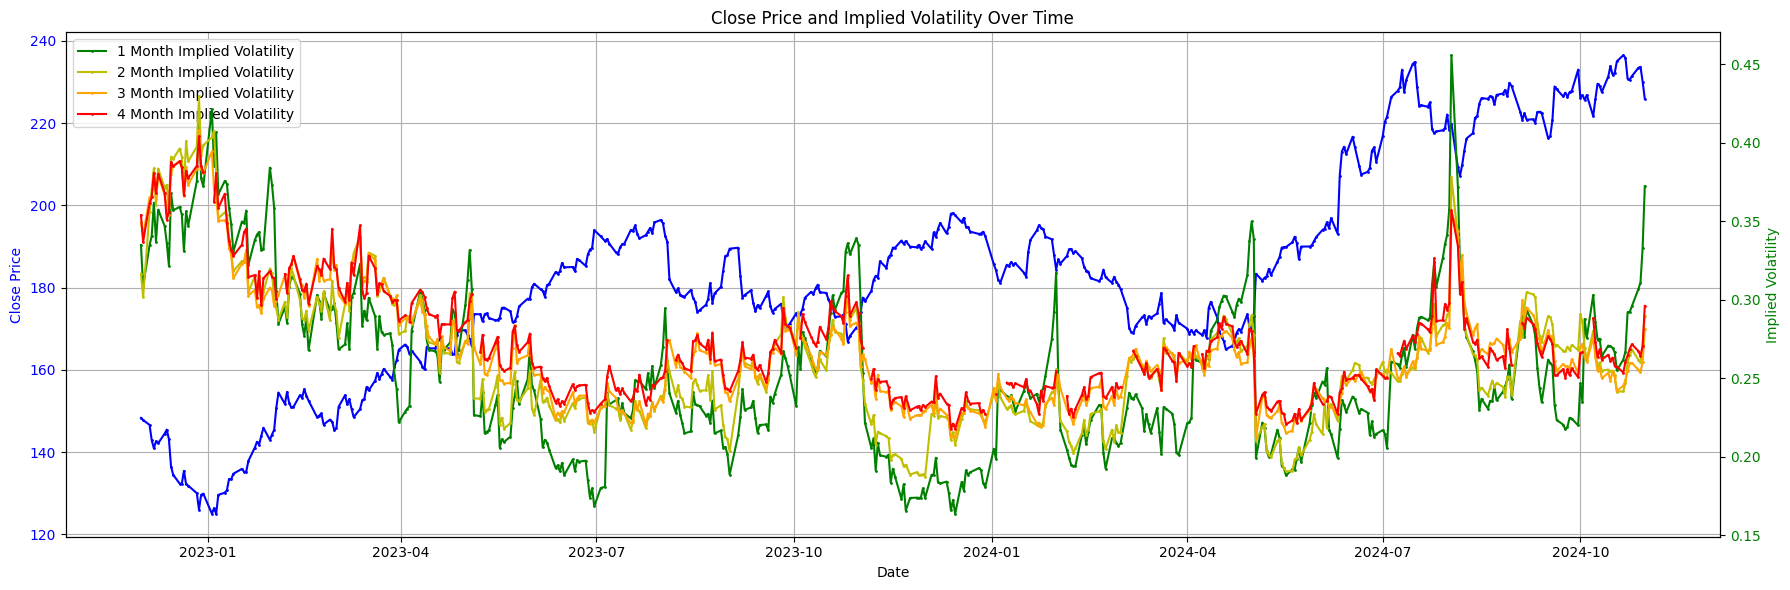

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(18, 6))  # Create a figure and a set of subplots

# Plot close price on the left y-axis
ax1.plot(merged_df_pivoted.index, merged_df_pivoted['_month_close_u'], label='_month_close_u', color='b', marker='o', markersize=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')  # Color the y-ticks

# Create a second y-axis for the implied volatility
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.plot(merged_df_pivoted.index, merged_df_pivoted['1_month_implied_volatility'], label='1 Month Implied Volatility', color='g', marker='o', markersize=1)
ax2.plot(merged_df_pivoted.index, merged_df_pivoted['2_month_implied_volatility'], label='2 Month Implied Volatility', color='y', marker='o', markersize=1)
ax2.plot(merged_df_pivoted.index, merged_df_pivoted['3_month_implied_volatility'], label='3 Month Implied Volatility', color='orange', marker='o', markersize=1)
ax2.plot(merged_df_pivoted.index, merged_df_pivoted['4_month_implied_volatility'], label='4 Month Implied Volatility', color='r', marker='o', markersize=1)

# Set labels and title for the right y-axis
ax2.set_ylabel('Implied Volatility', color='g')
ax2.tick_params(axis='y', labelcolor='g')  # Color the y-ticks

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add grid, title, and show plot
plt.title('Close Price and Implied Volatility Over Time')
ax1.grid()  # Optional: Add grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout
plt.show()

In [146]:
def calculate_realized_volatility(row, expiration):
    start_date = row['Date'] + pd.Timedelta(days=1)  # Day after the option pricing date
    end_date = row[expiration]
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)
    if str(end_date) == 'nan':
        return
    if end_date.date() not in merged_df_pivoted['Date'].values:
        return 
    # Filter daily returns for the specified date range
    returns_in_range = merged_df_pivoted[(merged_df_pivoted['Date'] >= start_date) & (merged_df_pivoted['Date'] <= end_date.date())]['_month_daily_return']

    # Calculate realized volatility if there are returns in the range
    if not returns_in_range.empty:
        realized_vol = np.std(returns_in_range, ddof=1) * np.sqrt(252)  # Annualizing based on trading days
        return realized_vol
    else:
        return np.nan

In [148]:
merged_df_pivoted['1_month_realized_volatility'] = merged_df_pivoted.apply(calculate_realized_volatility, axis=1,  args=('1_month_expiration_date',))
merged_df_pivoted['2_month_realized_volatility'] = merged_df_pivoted.apply(calculate_realized_volatility, axis=1,  args=('2_month_expiration_date',))
merged_df_pivoted['3_month_realized_volatility'] = merged_df_pivoted.apply(calculate_realized_volatility, axis=1,  args=('3_month_expiration_date',))
merged_df_pivoted['4_month_realized_volatility'] = merged_df_pivoted.apply(calculate_realized_volatility, axis=1,  args=('4_month_expiration_date',))


In [149]:
merged_df_pivoted.to_csv('volatility.csv')

In [ ]:
z = client.list_options_contracts(underlying_ticker = 'AAPL', raw=True, limit=1000, contract_type='call', as_of='2023-01-03')
data = json.loads(z.data.decode('utf-8'))
for d in data['results']:
    print(d)

In [ ]:
z = client.list_options_contracts(underlying_ticker = 'AAPL', raw=True, limit=1000, contract_type='call', as_of='2023-11-01')
data = json.loads(z.data.decode('utf-8'))
for c in data['results']:
    if c['expiration_date'] in contracts:
        print(c)

In [ ]:
dataRequest = client.get_aggs(ticker = 'O:AAPL231103C00172500', 
                              multiplier = 1,
                              timespan = 'day',
                              from_ = '2023-11-01',
                              to = '2023-11-01')
# list of polygon agg objects to DataFrame
optionData = pd.DataFrame(dataRequest)

#create Date column
optionData['Date'] = optionData['timestamp'].apply(
                          lambda x: pd.to_datetime(x*1000000))

optionData = optionData.set_index('Date')
optionData

In [10]:
from polygon import RESTClient
from datetime import datetime, timedelta
import pandas as pd
import json

# Initialize the client with your Polygon API key
api_key = "ftdnhkJhYOsOYJjqbGXi4Vxs7QuEOZYH"
client = RESTClient(api_key)

stockTicker = 'AAPL'

# empty list
data = []

# request financial statement data // add to list
for t in client.vx.list_stock_financials(ticker=stockTicker,
                                         filing_date_gte='2022-01-01'):
    data.append(t)
    


In [ ]:
z = client.list_options_contracts(underlying_ticker = 'AAPL', raw=True, limit=1000, contract_type='call', as_of='2023-11-01')
data = json.loads(z.data.decode('utf-8'))
for c in data['results']:
    print(c)

In [ ]:
for d in data:
    print(d.financials)

In [ ]:
print(dir(data[0].financials))

In [ ]:
print(data)
print(dir(data[0]))
print(data[0].financials)
print(dir(data[0].financials))
print(data[0].financials.income_statement)
print(dir(data[0].financials.income_statement))
print(dir(data[0].financials.income_statement.revenues))
print(data[0].financials.income_statement.revenues.value)

In [ ]:
z = client.get_options_contract(ticker = 'O:AAPL120106P00340000', raw=True, as_of='2012-01-01')
print(z.data.decode('utf-8'))

In [ ]:

z = client.list_options_contracts(underlying_ticker = 'AAPL', raw=True, limit=1000, contract_type='call', as_of='2023-11-01')
data = json.loads(z.data.decode('utf-8'))
for c in data['results']:
    print(c)

In [4]:
dataRequest = client.get_aggs(ticker = stockTicker, 
                              multiplier = 1,
                              timespan = 'day',
                              from_ = '2021-09-01',
                              to = '2100-01-01')



# list of polygon agg objects to DataFrame
priceData = pd.DataFrame(dataRequest)

#create Date column
priceData['Date'] = priceData['timestamp'].apply(
                          lambda x: pd.to_datetime(x*1000000))

priceData = priceData.set_index('Date')

In [ ]:
priceData.tail(250)